Creating your own pix2pix dataset
=================================



## Installation requirements

To run this notebook as well as the [07_visualizing_pix2pix_results.ipynb](07_visualizing_pix2pix_results.ipynb) notebook you might need to install some new Python packages. To do so, open a terminal and first make sure your environment is active
```
conda activate dmlap
```
and then
```
conda install -c conda-forge pycairo opencv scikit-image 
conda install -c conda-forge dlib mlxtend
pip install pyglet
```

If you have not done so already, you will also need to install the [py5canvas](https://github.com/colormotor/py5canvas) module locally. To do so, navigate to a directory of choice in the terminal (you will install py5canvas in that directory) and then write:

```
git clone https://github.com/colormotor/py5canvas.git
cd py5canvas
pip install -e .
```

### Updating py5canvas
If you already installed py5canvas, you will need to updated it to the latest version. Get used to this because you will likely have to update it often as it is work in progress:) To do so, navigate to the `py5canvas` directory in the terminal (using `cd`) and then
```
git pull
```

## Setting up 
Set your directories and the dataset specifics

-   `target_path` defines where your **target** images are located.
-   `source_path` defines where your **source** images are located, if you already have these. Otherwise, set this to an empty string `''`.
-   `dataset_path` defines where your pix2pix dataset will be saved.
-   `is_input_pix_to_pix` set this to `True` if the input dataset already consists of an source and target pairs. This will be the case if you want to modify an existing pix2pix dataset. In this case we need to extract only the target.
-   `input_target_index` if we are manipulating a dataset that is already a pix2pix dataset, this defines whether the target image is to the left (`0`) or to the right (`1`).

Note you will have to put exactly the path to your image directories here, this code does not recursively search for images. Also note that the most common use case for this system will be with you providing an dataset of targets (desired outputs) that you will process to create the corresponding inputs (e.g. with edge detection or finding face landmarks). In that case you should not worry about the `source_path` directory below.

Here, by default we will load the &ldquo;Face 2 comics&rdquo; dataset. Download the dataset from [https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic](https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic), unzip, and place the `face2comics_v1.0.0_by_Sxela` direcory in your dataset directory. This is already a &ldquo;pix2pix-friendly&rdquo; dataset consisting, however, of pairs of images that are separated. We will use the images to create an &ldquo;Edges to comics&rdquo; dataset, where we apply edge detection to a subset of the source images and leave the corresponding comic version unchanged.



In [1]:
import os

target_path = './datasets/face2comics_v1.0.0_by_Sxela/comics/'
source_path = './datasets/face2comics_v1.0.0_by_Sxela/face/'  # Only used if we already have source image examples
dataset_path = './datasets/edge2comics'

is_input_pix_to_pix = False
input_target_index = 1

## Load the images to process



Now let&rsquo;s load our target images, and optionally our source images if we have set the `source_path` directory



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import cv2
from tensorflow.keras.preprocessing import image
import glob
from tqdm.auto import tqdm

def load_image(path):
    size = (256, 256)
    if is_input_pix_to_pix: # In case we are already loading a pix2pix image
        size = (256, 512)
    img = image.load_img(path, target_size=size)
    img = image.img_to_array(img)
    # If we are loading a pix2pix dataset just extract the target
    if is_input_pix_to_pix:
        if input_target_index==0:
            img = img[:,:size[0],:]
        else:
            img = img[:,size[0]:,:]
    return img.astype(np.uint8)

def load_images_in_path(path):
    files = glob.glob(path + '/*')
    images = []
    for imgfile in tqdm(files): #, desc='Loading images in ' + path):
        img = load_image(imgfile)
        images.append(img)
    return images

target_images = load_images_in_path(target_path)
print('Loaded %d target images'%(len(target_images)))
if source_path:
    source_images = load_images_in_path(source_path)
    print('Loaded %d source images'%(len(source_images)))

100%|██████████| 10000/10000 [00:21<00:00, 470.95it/s]


Loaded 10000 target images


100%|██████████| 10000/10000 [00:21<00:00, 458.34it/s]

Loaded 10000 source images


## Define our transformation



The code below has a number of transformations already setup for you. These are:

-   `apply_canny_cv2` Applys Canny edge detection by using OpenCV. You can set two parameters (thresholds between 0 and 255) that will determine the result of the edge detection: `thresh1` and `thresh2`. Experiment with these values to adjust the results to your liking. Additional details can be seen [here](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de).
-   `apply_canny_skimage` Applys Canny edge detection by using [scikit-image](https://scikit-image.org). You can set one parameter, `sigma` that determines the number of edges. In general, a higher number will produce less edges. See [this](https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html) for additional details.
-   `apply_face_landmarks` Finds face landmarks in an image by using [mlxtend](http://rasbt.github.io/mlxtend/) and uses the Canvas API to draw these as polygons. Note that this function will fail if the face detector cannot find a face in the image.
-   `get_transformed` simply gets an already transformed image from the directory specified in `source_path`.  This will not work if this directory is not specified. You can optionally set an additional transformation to the image by setting the `transform` parameter to one of the functions above. For example setting `transform=apply_canny_skimage` will apply the Canny edge detection algorithm to the loaded source image.

Set the `image_transformation` in the code below to the function that describes the transformation you want to apply.
If you feel confident, you can extend this to other image transformations by duplicating one of the functions and adapting it to your needs.

In the example below we will use the `get_transformed` and set `transform=apply_canny_skimage`. This means that we will load the source (face image) from the input dataset, and apply edge detection to that image for constructing our dataset.



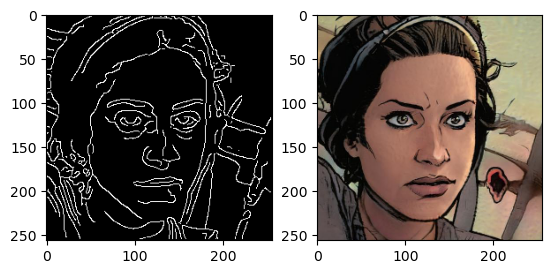

In [6]:
from skimage import feature, filters

def apply_canny_cv2(index, img, thresh1=160, thresh2=250):
    import cv2
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(grayimg, thresh1, thresh2)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def apply_canny_skimage(index, img, sigma=1.5):
    import cv2
    from skimage import feature
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def apply_face_landmarks(index, img, stroke_weight=2):
    from py5canvas import canvas
    from mlxtend.image import extract_face_landmarks

    def landmark_polylines(landmarks):
        # https://pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
        landmarks = np.array(landmarks).astype(np.float32)
        indices = [list(range(0, 17)),
                list(range(17, 22)),
                list(range(22, 27)),
                list(range(27, 31)),
                list(range(31, 36)),
                list(range(36, 42)) + [36],
                list(range(42, 48)) + [42],
                list(range(48, 60)) + [48],
                list(range(60, 68)) + [60]]
        return [landmarks[I] for I in indices]


    c = canvas.Canvas(256, 256)
    c.background(0)
    landmarks = extract_face_landmarks(img)
    if landmarks is None:
        return None
    c.stroke_weight(stroke_weight)
    c.no_fill()
    c.stroke(255)
    paths = landmark_polylines(landmarks)
    for path in paths:
        c.polyline(path)
    return c.get_image()

# As it is, this version loads an image from the source_image directory and applies the Canny edge detection
# algorithm to it. Set transform=None if you just want to load that image without processing
def load_transformed(index, img, transform=apply_canny_skimage):
    if transform is not None:
        return transform(index, source_images[index])
    return source_images[index]

# Set this to the tranformation you want to apply. If you are only working with a single folder of images that you
# want to process, set image_transformation to one of the filtering operations above,
# e.g. 
# image_tranformation = apply_canny_skimage

image_transformation = load_transformed

img = target_images[0]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image_transformation(0, img))
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.show()

## Create the dataset!



Here we loop through all the target images, generate the source image and stitch these together into a single image. The input image directory might contain more than the desired number of images. If we want to process a lower number, set the `num_images` variable to a non-zero value.



In [8]:
import random
from tqdm import tqdm
from skimage import io

target_index = 0
num_images = 200
shuffle = True
image_indices = list(range(len(target_images)))
if shuffle:
    random.shuffle(image_indices)
if num_images != 0:
    image_indices = image_indices[:num_images]

os.makedirs(dataset_path, exist_ok=True)

index = 1
for i in tqdm(image_indices, desc='Saving dataset to ' + dataset_path):
    target = target_images[i]
    source = image_transformation(i, target)
    if source is None:
        print('Failed to transform image %d of %d'%(i+1, len(image_indices)))
        continue

    if target_index==1:
        combined = np.hstack([source, target])
    else:
        combined = np.hstack([target, source])
    io.imsave(os.path.join(dataset_path, '%d.png'%(index)), combined)
    index += 1

Saving dataset to ./datasets/edge2comics: 100%|██████████| 200/200 [00:14<00:00, 13.94it/s]
